In [1]:
import numpy as np
from scipy.ndimage import laplace
import matplotlib.pyplot as plt

In [13]:
## 2023_12_08 Tweez pLPT20 Pos 12
log_params = {"A": 12.088146235198375, "mu_m": 0.029873438792180063, "lambda": 12.5520052803782}
incubation_time = 5 * 60 * 60 # pos 12
offset = incubation_time / 60 / 10
#incubation_time = 5.5 * 60 * 60 # pos 7
def logistic_growth_rate(t, log_params):
    # Convert time to seconds and add incubation time
    t = (t + incubation_time) / 60
    A = log_params['A']
    mu_m = log_params['mu_m']
    l = log_params['lambda']
    gr = 4 * mu_m * np.exp(4 * mu_m / A * (l - t) + 2) / (1 + np.exp(4 * mu_m / A * (l - t) + 2))**2
    return gr / 60

def logistic(t, log_params):
    # Convert time to seconds and add incubation time
    t = (t + incubation_time) / 60
    A = log_params['A']
    mu_m = log_params['mu_m']
    l = log_params['lambda']
    log_B = A / (1 + np.exp(4 * mu_m / A * (l - t) + 2))
    return np.exp(log_B)

In [14]:
edt = np.load('results/edt.npy')
nt,nx,ny = edt.shape

In [15]:
from skimage.io import imread

im = imread('10x_1.0x_MC4100_pLPT20&41_TiTweez_2_MMStack_Pos12.ome.tif')
#im = imread('../../2023_12_04_tweez/Pos 10/10x_1.0x_MC4100_pLPT107&41_TiTweez_1_MMStack_Pos10.ome.tif')
#im = im[:,:,:,:]
#im = im.transpose([0,2,3,1])
im = im[:,:,:,2:]
print(im.shape)

<tifffile.TiffFile '10x_1.0x_MC4100…ck_Pos12.ome.tif'> MMStack series is missing files. Returning subset (1, 406, 4, 1) of (36, 432, 4, 1)


(406, 1024, 1024, 2)


In [16]:
y,x = np.meshgrid(np.arange(nx), np.arange(ny))
edt0 = edt[-1,:,:]
minx = x[edt0>0].min()
maxx = x[edt0>0].max()
miny = y[edt0>0].min()
maxy = y[edt0>0].max()
w = maxx - minx
h = maxy - miny
w = int(w//2) * 2
h = int(h//2) * 2

print(w,h)
pad = 256

crop_edt = np.zeros((nt,w+2*pad,h+2*pad))
crop_im = np.zeros((nt,w+2*pad,h+2*pad,2))
print(crop_edt.shape)

for t in range(nt):
    tedt = edt[t,:,:]
    tim = im[t,:,:,:]
    cx = int(x[tedt>0].mean())
    cy = int(y[tedt>0].mean())
    crop_edt[t,:,:] = tedt[cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad]
    crop_im[t,:,:] = tim[cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad,:]

448 440
(406, 960, 952)


In [53]:
from skimage.transform import warp_polar
from scipy.ndimage import median_filter
#plt.figure(figsize=(12,12))
#plt.imshow(warp_polar(crop_im[90,:,:,3] + 1e4 *  (np.abs(crop_edt[90,:,:]-50)<0.5), center=(nx/2,ny/2), radius=200))
#plt.colorbar()

nang = 2880
ti,ri = 100,54

fluc = np.zeros((nt,nang,200,2))
for ti in range(nt):
    for c in range(2):
        wim = warp_polar(median_filter(crop_im[ti,:,:,c], 3), center=(nx/2,ny/2), radius=200, output_shape=(nang,200))
        wimtrend = warp_polar(gaussian_filter(crop_im[ti,:,:,c], 16), center=(nx/2,ny/2), radius=200, output_shape=(nang,200))
        fluc[ti,:,:,c] = (wim - wimtrend) / wimtrend


In [54]:
fluc_corr = np.zeros((nt,200))
for ti in range(nt):
    for ri in range(200):
        x = fluc[ti,:,ri,0]
        y = fluc[ti,:,ri,1]
        fluc_corr[ti,ri] = np.corrcoef(x, y)[0,1]

/Users/timrudge/opt/anaconda3/envs/infotracking/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/timrudge/opt/anaconda3/envs/infotracking/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


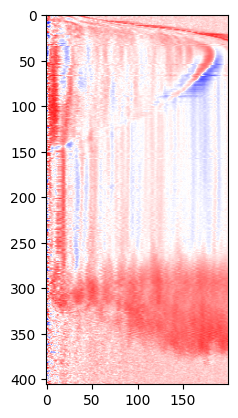

In [55]:
plt.imshow(fluc_corr[:,:], vmin=-1, vmax=1, cmap='bwr')

0.8034065396725999


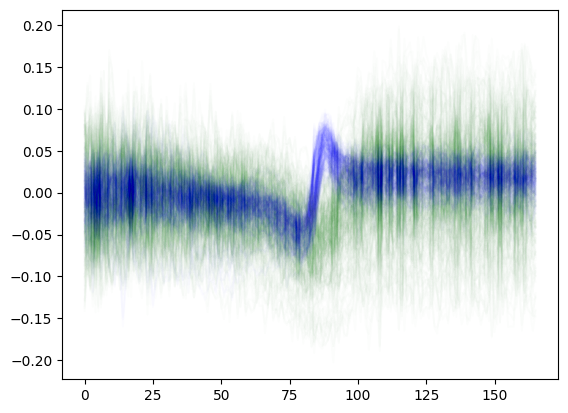

In [72]:
rs = [50] #,75,100,125,150]
for r in rs:
    _ = plt.plot(fluc[50:216,::10,r,0], 'g-', alpha=0.01)
    _ = plt.plot(fluc[50:216,::10,r,1], 'b-', alpha=0.01)
    print(np.corrcoef(fluc[50:216,::10,r,0], fluc[50:216,::10,r,1])[0,1])
#_ = plt.plot(fluc[50:,::10,51,1], 'g-', alpha=0.01)
#_ = plt.plot(fluc[50:,::10,51,2], 'b-', alpha=0.01)

(array([119., 149., 443., 447., 595., 535., 321., 179.,  53.,  39.]),
 array([-0.11296997, -0.08998972, -0.06700948, -0.04402923, -0.02104898,
         0.00193127,  0.02491151,  0.04789176,  0.07087201,  0.09385225,
         0.1168325 ]),
 <BarContainer object of 10 artists>)

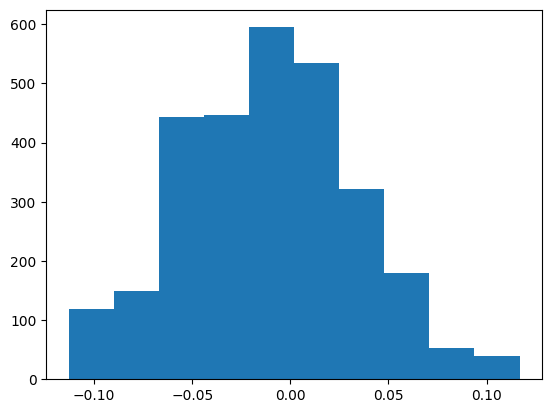

In [70]:
plt.hist(fluc[75,:,50,0])

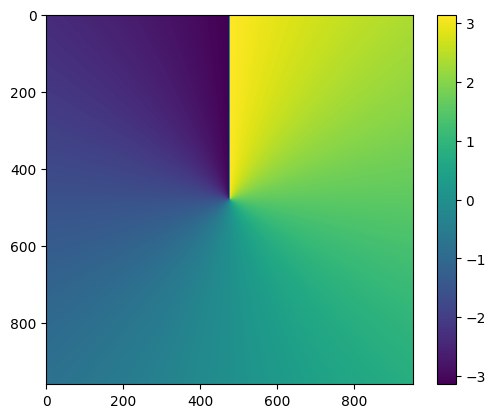

In [7]:
nt,nx,ny = crop_edt.shape
y,x = np.meshgrid(np.arange(ny), np.arange(nx))
x = x - nx/2
y = y - ny/2
angle = np.arctan2(y, x)
plt.imshow(angle)
plt.colorbar()

In [6]:
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.ndimage import gaussian_filter, distance_transform_edt

def bimodality_coefficient(x):
    n = len(x)
    if n < 3:
        return np.nan
    
    k = kurtosis(x, fisher=False)  # Set fisher=False to get Pearson's definition of kurtosis
    g = skew(x)
    
    # Bimodality coefficient
    bc = (g**2 + 1) / (k + 3 * ((n - 1)**2) / ((n - 2) * (n - 3)))
    return bc

rs = np.arange(int(np.nanmax(crop_edt)))
nt = crop_edt.shape[0]
rcorr = np.zeros((nt, len(rs))) + np.nan
kymo = np.zeros((nt, len(rs), 2)) + np.nan
bimodality = np.zeros((nt, len(rs))) + np.nan  # Array to store bimodality coefficient

t0,t1 = 50,216
mask = (crop_edt[t0:t1,:,:]>0) * 1
tmask = mask.mean(axis=0)
tmask = gaussian_filter(tmask, 8)>0.5
tedt = distance_transform_edt(tmask)
for t in range(t0,t1):
    print(f'Computing frame {t+1}/{nt}')
    for ir in range(len(rs)):
        #tedt = crop_edt[t, :, :]
        tim0 = crop_im[t, :, :, 0]
        tim1 = crop_im[t, :, :, 1]
        x = tim0[np.abs(tedt - rs[ir]) < 8]
        y = tim1[np.abs(tedt - rs[ir]) < 8]
        if len(x) > 10:
            C = np.corrcoef(x, y)
            rcorr[t, ir] = C[0, 1]
            kymo[t, ir, 0] = x.mean()
            kymo[t, ir, 1] = y.mean()
            # Calculate and store the bimodality coefficient for x and y
            #bimodality[t, ir] = bimodality_coefficient(y)

# Now rcorr contains the correlation coefficients and bimodality contains the bimodality coefficients


Computing frame 51/406
Computing frame 52/406
Computing frame 53/406
Computing frame 54/406
Computing frame 55/406
Computing frame 56/406
Computing frame 57/406
Computing frame 58/406
Computing frame 59/406
Computing frame 60/406
Computing frame 61/406
Computing frame 62/406
Computing frame 63/406
Computing frame 64/406
Computing frame 65/406
Computing frame 66/406
Computing frame 67/406
Computing frame 68/406
Computing frame 69/406
Computing frame 70/406
Computing frame 71/406
Computing frame 72/406
Computing frame 73/406
Computing frame 74/406
Computing frame 75/406
Computing frame 76/406
Computing frame 77/406
Computing frame 78/406
Computing frame 79/406
Computing frame 80/406
Computing frame 81/406
Computing frame 82/406
Computing frame 83/406
Computing frame 84/406
Computing frame 85/406
Computing frame 86/406
Computing frame 87/406
Computing frame 88/406
Computing frame 89/406
Computing frame 90/406
Computing frame 91/406
Computing frame 92/406
Computing frame 93/406
Computing f

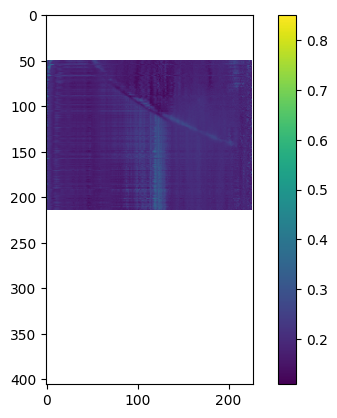

In [231]:
plt.imshow(bimodality)
plt.colorbar()

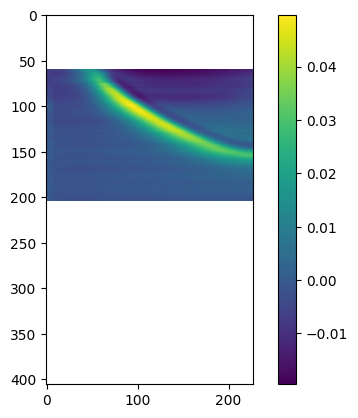

In [9]:
from scipy.signal import savgol_filter

rho = kymo[:,:,0] / kymo[:,:,1]
lrho = np.log(rho)
dlrho = savgol_filter(lrho, 21, 3, deriv=1, axis=0)
plt.imshow(dlrho)
plt.colorbar()

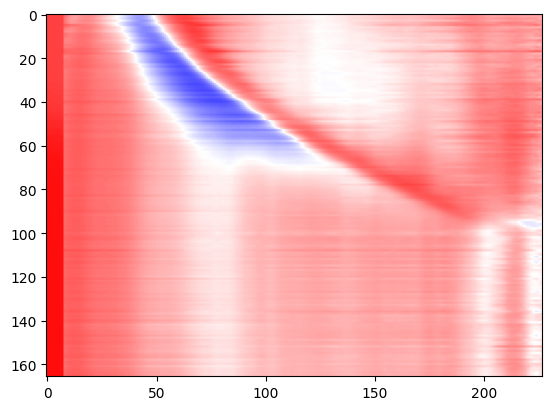

In [7]:
plt.imshow(rcorr[50:216,:] , cmap='bwr', vmin=-1, vmax=1)
#plt.colorbar()

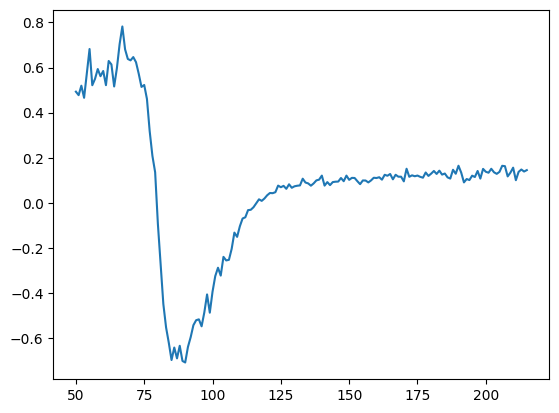

In [11]:
plt.plot(rcorr[:,75])

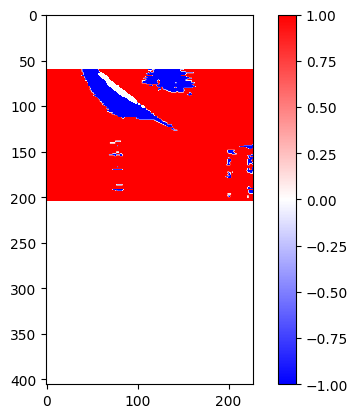

In [10]:
from scipy.signal import savgol_filter

drcorr = savgol_filter(rcorr, 21, 3, deriv=1, axis=0)
idx1 = np.abs(drcorr)<0.1
idx2 = np.abs(rcorr)<0.1
rcmask = np.zeros_like(rcorr) + np.nan
rcmask[idx1] = np.sign(rcorr[idx1])
rcmask[idx2] = np.sign(drcorr[idx2])
plt.imshow(rcmask, cmap='bwr')
plt.colorbar()
#plt.contour((drcorr>0) * (rcorr>0) , [0], colors=['r'])
#plt.contour((drcorr>0) * (rcorr<0) , [0], colors=['b'])


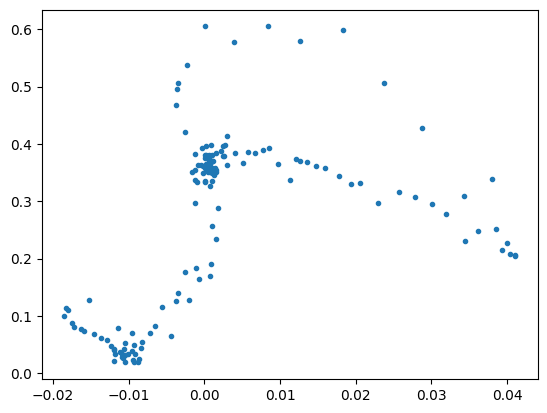

In [249]:
plt.plot(dlrho[:,150], rcorr[:,150], '.')

91
91 80
227
-0.5352837743128195
0.20404381907331348


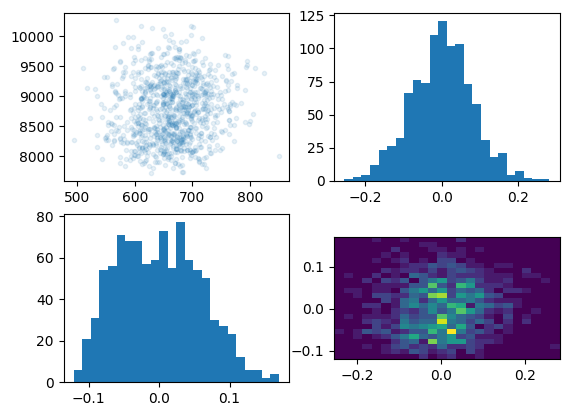

In [243]:
idx = np.nanargmax(dlrho[:,80]) # np.where(bimodality[:,100].ravel()>0.555)[0] # np.nanargmin(corrd[:,:,:])
#idx = np.random.choice(idx, 1)[0]
print(idx)
it,ir = idx,80
#it,ir = np.unravel_index(idx, bimodality.shape)
print(it,ir)
print(int(np.nanmax(crop_edt)))

print(rcorr[it,ir])
print(bimodality[it,ir])

t0,t1 = 50,216
mask = (crop_edt[t0:t1,:,:]>0) * 1
tmask = mask.mean(axis=0)
tmask = gaussian_filter(tmask, 8)>0.5
tedt = distance_transform_edt(tmask)

tim0 = crop_im[it,:,:,0]
tim1 = crop_im[it,:,:,1]
x = tim0[np.abs(tedt-r)<1]
y = tim1[np.abs(tedt-r)<1]

plt.subplot(2, 2, 1)
plt.plot(x, y, '.', alpha=0.1)
plt.subplot(2, 2, 2)
_ = plt.hist((x-x.mean()) / x.mean(), bins=24)
plt.subplot(2, 2, 3)
_ = plt.hist((y-y.mean()) / y.mean(), bins=24)
plt.subplot(2, 2, 4)
h, xedges, yedges, him = plt.hist2d((x-x.mean()) / x.mean(), (y-y.mean()) / y.mean(), bins=24)
plt.imshow(h, aspect='equal')

[[-0.05859016 -0.06694476]
 [ 0.05958531  0.06808182]]
[[0 0]
 [1 1]]
[[[0.00667906 0.00078549]
  [0.00078549 0.00128053]]

 [[0.00923409 0.00043645]
  [0.00043645 0.00092797]]]


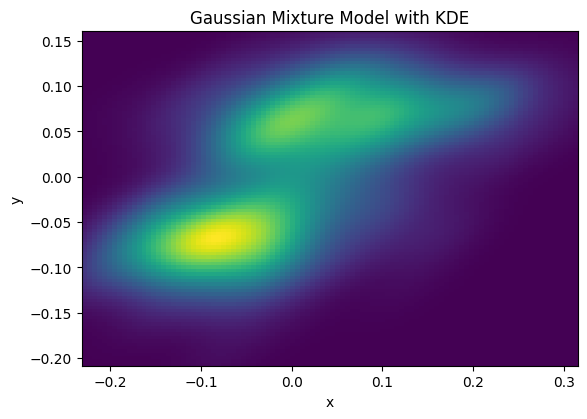

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from scipy.stats import gaussian_kde

# Function to draw ellipses for GMM components
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, _ = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(xy=position, width=nsig * width, height=nsig * height,
                             angle=angle, alpha=0.5 / nsig, **kwargs))

def fit_gmm(x, y):
    data = np.vstack([(x-x.mean())/x.mean(), (y-y.mean())/y.mean()])

    # Fit a Gaussian Mixture Model with 2 components
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(data.T)

    # Predict the component labels
    labels = gmm.predict(data.T)
    return gmm, labels

def plot_kde(x, y):
    data = np.vstack([(x-x.mean())/x.mean(), (y-y.mean())/y.mean()])
    # Fit the KDE
    kde = gaussian_kde(data)

    # Create a grid of points for KDE
    xmin, ymin = data.min(axis=1)
    xmax, ymax = data.max(axis=1)
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    f = np.reshape(kde(positions).T, xx.shape)

    # Plot the KDE and the Gaussian Mixture components
    fig, ax = plt.subplots()
    ax.imshow(np.rot90(f), cmap='viridis', extent=[xmin, xmax, ymin, ymax], aspect='equal')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Gaussian Mixture Model with KDE')
    plt.show()

    #ax.contour(xx, yy, f, colors='k')
    return ax

def draw_ellipses(gmm, ax):
    # Plot the ellipses for each GMM component
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, ax=ax, edgecolor='k', linestyle='--', fill=True)

gmm,labels = fit_gmm(x, y)
print(gmm.means_)
print((np.sign(gmm.means_)==1)*1)
print(gmm.covariances_)
#fig,ax = plt.subplots(1,1) 
ax = plot_kde(x, y)
draw_ellipses(gmm, ax)



In [73]:
from scipy.ndimage import distance_transform_edt

def get_traces(r, t0, t1):
    ntt = t1 - t0
    mask = (crop_edt[t0:t1,:,:]>0) * 1
    tmask = mask.mean(axis=0)
    tmask = gaussian_filter(tmask, 8)>0.5
    tedt = distance_transform_edt(tmask)
    tedt = tedt.ravel()
    idx = np.where(np.abs(tedt-r)<0.5)[0]
    npix = len(idx)
    xx = np.arange(t0, t1)
    yy = np.zeros((ntt,npix))
    zz = np.zeros((ntt,npix))
    ang = np.zeros((ntt,npix))
    for t in range(t0, t1):
        tim0 = crop_im[t,:,:,0].ravel()
        tim1 = crop_im[t,:,:,1].ravel()
        y = tim0[idx]
        z = tim1[idx]
        yy[t-t0,:] = (y - np.nanmean(y)) / np.nanmean(y)
        zz[t-t0,:] = (z - np.nanmean(z)) / np.nanmean(z)
        ang[t-t0,:] = angle.ravel()[idx]
    return xx,yy,zz,ang

[ 30.          71.87376372 113.74752745 155.62129117 197.49505489]


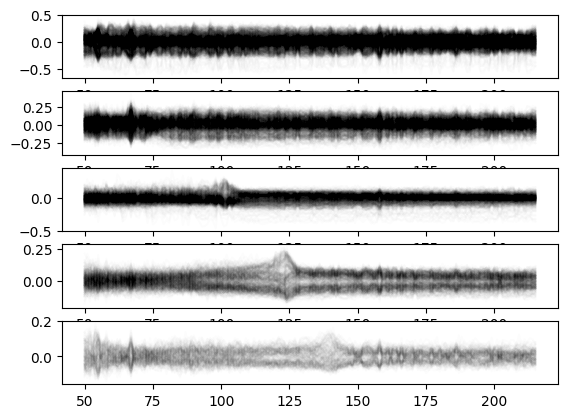

In [145]:
from scipy.stats import gaussian_kde

t0,t1 = 50,216
ntt = t1 - t0
rs = np.linspace(30, crop_edt.max()-30, 5) # [30,70,110,150,190] # np.nanmax(crop_edt)
print(rs)
for r in range(len(rs)):
    xx,yy,zz,ang = get_traces(rs[r], t0, t1)
    plt.subplot(len(rs),1,r+1)
    _ = plt.plot(xx, zz[:,:], 'k', alpha=0.01)
    #plt.ylim([-0.5,0.5])

50 216
(406, 227)


Text(0.5, 0, 'Time (frames)')

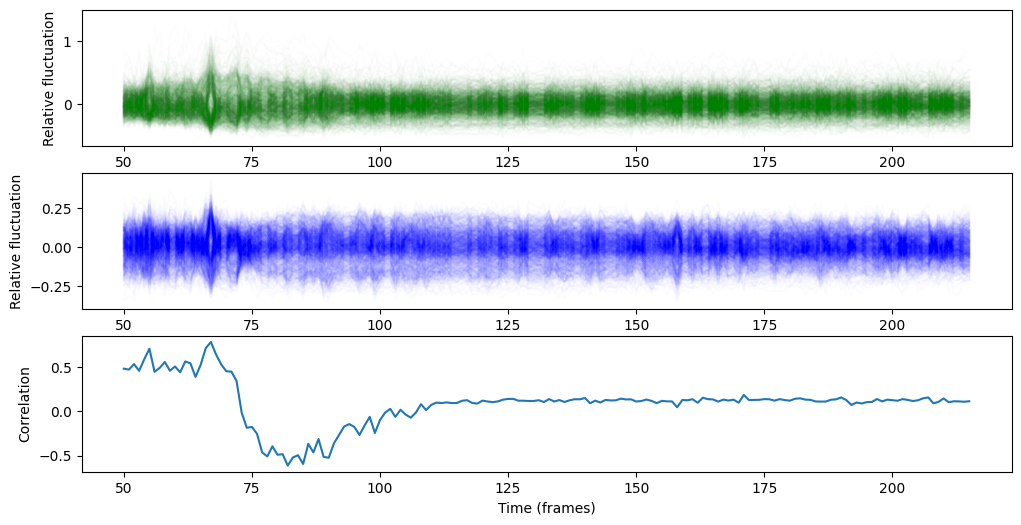

In [115]:
xx,yy,zz,ang = get_traces(70, t0, t1)

plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
_ = plt.plot(xx, yy[:,:], 'g', alpha=0.01)
plt.ylabel('Relative fluctuation')
plt.subplot(3,1,2)
_ = plt.plot(xx, zz[:,:], 'b', alpha=0.01)
plt.xlabel('Time (frames)')
plt.ylabel('Relative fluctuation')
plt.subplot(3,1,3)
print(t0, t1)
print(rcorr.shape)
_ = plt.plot(xx, rcorr[t0:t1,70])
plt.ylabel('Correlation')
plt.xlabel('Time (frames)')


(166, 490)


(-0.5, 0.5)

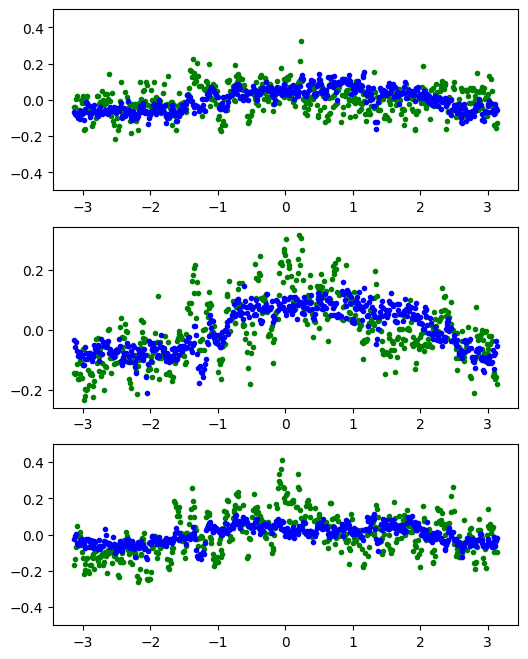

In [76]:
from scipy.stats import gaussian_kde

t0,t1 = 50,216
ntt = t1 - t0
xx,yy,zz,ang = get_traces(150, t0, t1)
print(ang.shape)
plt.figure(figsize=(6,8))
plt.subplot(3,1,1)
_ = plt.plot(ang[100-t0,:], yy[100-t0,:], 'g.') # , alpha=0.01)
_ = plt.plot(ang[100-t0,:], zz[100-t0,:], 'b.') # , alpha=0.01)
plt.ylim([-0.5,0.5])
plt.subplot(3,1,2)
_ = plt.plot(ang[125-t0,:], yy[125-t0,:], 'g.') # , alpha=0.01)
_ = plt.plot(ang[125-t0,:], zz[125-t0,:], 'b.') # , alpha=0.01)
plt.subplot(3,1,3)
_ = plt.plot(ang[150-t0,:], yy[150-t0,:], 'g.') # , alpha=0.01)
_ = plt.plot(ang[150-t0,:], zz[150-t0,:], 'b.') # , alpha=0.01)
plt.ylim([-0.5,0.5])

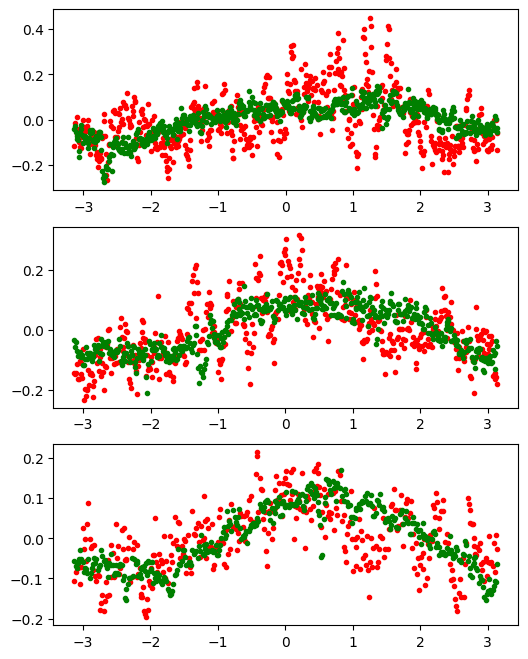

In [77]:
t0,t1 = 50,216
ntt = t1 - t0
rs = [130,150,170]
plt.figure(figsize=(6,8))
for ri in range(len(rs)):
    xx,yy,zz,ang = get_traces(rs[ri], t0, t1)
    plt.subplot(3, 1, ri+1)
    _ = plt.plot(ang[125-t0,:], yy[125-t0,:], 'r.') #, alpha=0.1)
    _ = plt.plot(ang[125-t0,:], zz[125-t0,:], 'g.') #, alpha=0.1)
#plt.ylim([-0.5,0.5])

(199,)


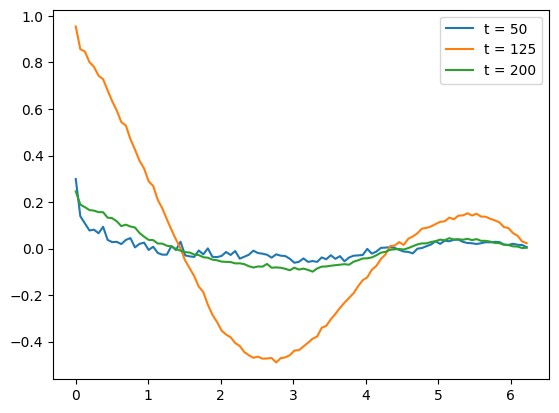

In [19]:
from scipy.signal import correlate, correlation_lags
from scipy.interpolate import interp1d

t0,t1 = 50,216
ntt = t1 - t0
xx,yy,zz,ang = get_traces(150, t0, t1)
sxx = np.linspace(-np.pi, np.pi, 100)

#plt.subplot(3,1,1)
sy = zz[50-t0,:]
sx = ang[50-t0,:]
s = interp1d(sx, sy, bounds_error=False, fill_value='extrapolate')(sxx)
lags = correlation_lags(len(s), len(s)) * np.pi * 2 / 100
idx = (lags>=0)
ac = correlate(s, s)
_ = plt.plot(lags[idx], ac[idx], '-') # , alpha=0.01)
#plt.subplot(3,1,2)
sy = zz[125-t0,:]
sx = ang[125-t0,:]
s = interp1d(sx, sy, bounds_error=False, fill_value='extrapolate')(sxx)
lags = correlation_lags(len(s), len(s)) * np.pi * 2 / 100
idx = (lags>=0)
ac = correlate(s, s)
_ = plt.plot(lags[idx], ac[idx], '-') # , alpha=0.01)
print(ac.shape)
#plt.subplot(3,1,3)
sy = zz[200-t0,:]
sx = ang[200-t0,:]
s = interp1d(sx, sy, bounds_error=False, fill_value='extrapolate')(sxx)
lags = correlation_lags(len(s), len(s)) * np.pi * 2 / 100
idx = (lags>=0)
ac = correlate(s, s)
_ = plt.plot(lags[idx], ac[idx], '-') # , alpha=0.01)

plt.legend(['t = 50', 't = 125', 't = 200'])

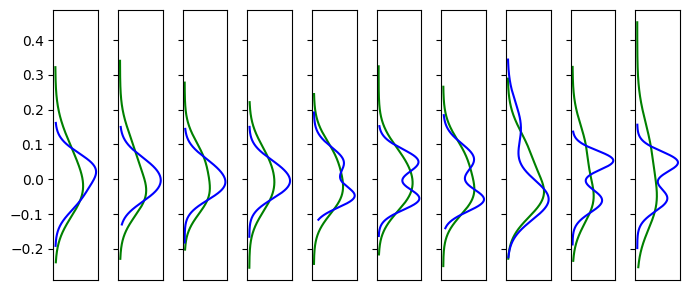

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

def plot_gmm(yyy, ax, orientation='vertical', color='r'):
    # Plot histogram
    #ax.hist(yyy, bins=24, density=True, alpha=0.3, color=color, orientation=orientation)

    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=2, random_state=42)  # Adjust n_components as needed
    gmm.fit(yyy.reshape(-1, 1))

    # Plot the GMM components
    x = np.linspace(min(yyy), max(yyy), 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    responsibilities = gmm.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    if orientation=='vertical':
        ax.plot(x, pdf, color=color, label='Total PDF')
        #ax.plot(x, pdf_individual, '--', label='Individual Gaussians')
    else:
        ax.plot(pdf, x, color=color, label='Total PDF')
        #ax.plot(pdf_individual, x, '--', label='Individual Gaussians')
    #ax.legend()

t0,t1 = 50,216
xx,yy,zz,ang = get_traces(150, t0, t1)
ts = np.arange(50, 150, 10) #
fig,axs = plt.subplots(1, len(ts), sharey=True, figsize=(7,3))
for t in range(len(ts)):    
    #axs[t].hist(yy[xx==ts[t]], bins=32)
    plot_gmm(yy[xx==ts[t],:].transpose(), axs[t], orientation='horizontal', color='g')
    plot_gmm(zz[xx==ts[t],:].transpose(), axs[t], orientation='horizontal', color='b')
    #axs[t].set_title(f't = {ts[t]}')
    axs[t].set_xticks([])
plt.tight_layout()

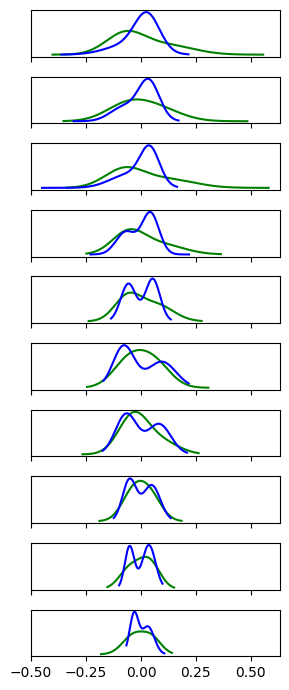

In [98]:
rs = np.linspace(100, 200, 10) #[45,50,55] # np.arange(100,200,20)
fig,axs = plt.subplots(len(rs), 1, sharex=True, figsize=(3,7))
for ri in range(len(rs)):  
    xx,yy,zz,ang = get_traces(rs[ri], t0, t1)  
    #axs[ri].hist(zz[xx==90,:].transpose(), bins=24, density=True, alpha=0.3, color='g')
    #axs[ri].hist(ww[xx==90,:].transpose(), bins=24, density=True, alpha=0.3, color='b')
    plot_gmm(yy[xx==125,:].transpose(), axs[ri], color='g')
    plot_gmm(zz[xx==125,:].transpose(), axs[ri], color='b')
    #axs[ri].set_title(f'r = {rs[ri]}')
    axs[ri].set_yticks([])
plt.tight_layout()

In [17]:
nt,nx,ny = crop_edt.shape
offset = incubation_time / 60 / 10
ntt = nt + int(offset)
crop_edt = np.zeros((ntt,nx,ny))
y,x = np.meshgrid(np.arange(ny), np.arange(nx))
cx,cy = nx/2, ny/2
R = np.sqrt((x-cx)**2 + (y-cy)**2)
for t in range(ntt):
    area = logistic(t * 10 * 60 - offset * 10 * 60, log_params)
    radius = np.sqrt(area / np.pi)
    crop_edt[t,:,:] = radius - R
    tedt = crop_edt[t,:,:]
    tedt[tedt<0] = 0 
    crop_edt[t,:,:] = tedt

In [18]:
def split_image_into_blocks(img, block_size):
    img_array = np.array(img)

    # Get the dimensions of the image
    nt, height, width, channels = img_array.shape

    # Calculate the number of blocks along the height and width
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    # Create an array to hold the blocks
    blocks = np.zeros((nt, num_blocks_y, num_blocks_x, block_size, block_size, channels))

    # Extract blocks and store them in the array
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            for c in range(channels):
                for t in range(nt):
                    blocks[t, i, j, :, :, c] = img_array[t, i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size, c]
    return blocks

def split_edt_into_blocks(img, block_size):
    img_array = np.array(img)

    # Get the dimensions of the image
    nt, height, width = img_array.shape

    # Calculate the number of blocks along the height and width
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    # Create an array to hold the blocks
    blocks = np.zeros((nt, num_blocks_y, num_blocks_x, block_size, block_size))

    # Extract blocks and store them in the array
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            for t in range(nt):
                blocks[t, i, j, :, :] = img_array[t, i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
    return blocks

edt_blocks = split_edt_into_blocks(crop_edt, 16)
im_blocks = split_image_into_blocks(crop_im, 16)
crop_edt_low = edt_blocks.mean(axis=(3,4))
crop_im_low = im_blocks.mean(axis=(3,4))
print(crop_im_low.shape)


(406, 60, 59, 2)


In [19]:
#from skimage.transform import downscale_local_mean

#print(crop_edt.shape)
#crop_edt_low = np.zeros((ntt,60,60))
#crop_im_low = np.zeros((nt,60,60,2))

#for t in range(ntt):
#    edt_low = downscale_local_mean(crop_edt[t,:,:], (16,16))
#    crop_edt_low[t,:,:] = edt_low

#for t in range(nt):
#    im_low = downscale_local_mean(crop_im[t,:,:], (16,16,1))
#    crop_im_low[t,:,:] = im_low

crop_edt = crop_edt_low
crop_im = crop_im_low
print(crop_edt.shape)
ntt,nx,ny = crop_edt.shape
nt,nx,ny,nc = crop_im.shape

crop_im[crop_edt[int(offset):,:,:]==0] = np.nan

(436, 60, 59)


In [345]:
np.log(2) / (1e-5) / 60 / 60

19.254088348887368

In [323]:
nt,nbx,nby,nxx,nyy,nc = im_blocks.shape

cov = np.zeros((nt,nbx,nby,2,2)) + np.nan
corr = np.zeros((nt,nbx,nby)) + np.nan
pp = np.zeros((nt,nbx,nby,2)) + np.nan
for bx in range(nbx):
    for by in range(nby):
        for t in range(nt):
            mask = np.sum(edt_blocks[t + int(offset), bx, by,:,:]>0)
            if mask==256:
                x = im_blocks[t,bx,by,:,:,0]
                y = im_blocks[t,bx,by,:,:,1]
                x = x[edt_blocks[t + int(offset),bx,by,:,:]>0]
                y = y[edt_blocks[t + int(offset),bx,by,:,:]>0]
                if np.sum(np.isnan(x))==0:
                    C = np.cov(x.ravel(), y.ravel())
                    cov[t,bx,by,:,:] = C
                    corr[t,bx,by] = np.corrcoef(x.ravel(), y.ravel())[0,1]
                    p = np.polyfit(x.ravel(), y.ravel(), deg=1)
                    pp[t,bx,by,:] = p

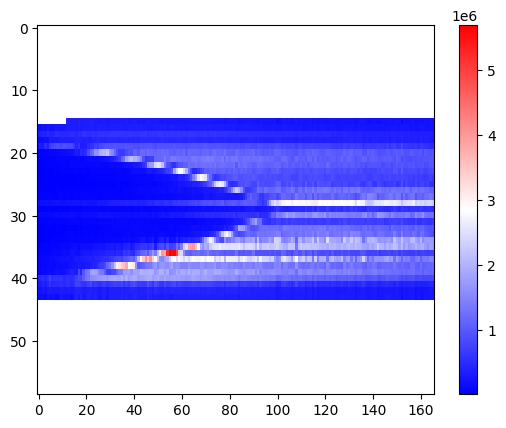

In [326]:
plt.imshow(cov[50:216,int(nbx//2),:,1,1].transpose(), aspect='auto', cmap='bwr', interpolation='none')
plt.colorbar()

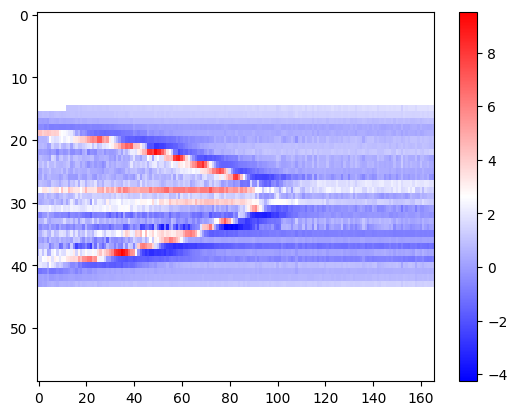

In [120]:
plt.imshow(pp[50:216,int(nbx//2),:,0].transpose(), aspect='auto', cmap='bwr', interpolation='none')
plt.colorbar()

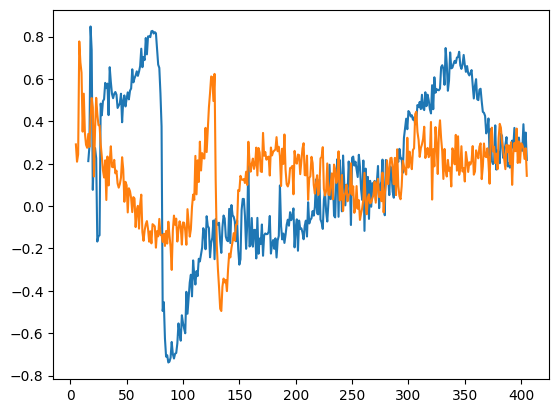

In [11]:
plt.plot(corr[:,20,30])
plt.plot(corr[:,25,30])

52008
14 41 29
[[ 1.         -0.87330909]
 [-0.87330909  1.        ]]
nan
[[1.         0.31195347]
 [0.31195347 1.        ]]


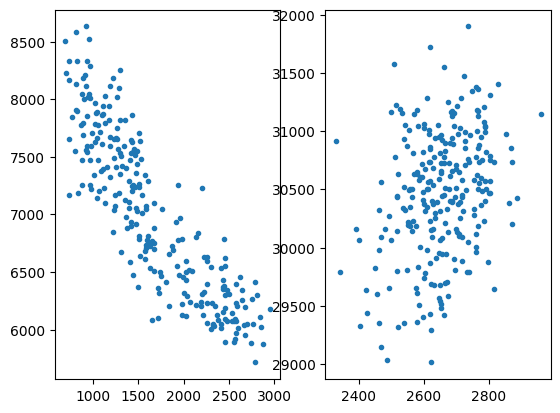

In [89]:
idx = np.nanargmin(corr[50:,:,:])
print(idx)
it,ix,iy = np.unravel_index(idx, corr.shape)
print(it,ix,iy)
plt.subplot(1, 2, 1)

x = im_blocks[it + 50,ix,iy,:,:,0].ravel()
y = im_blocks[it + 50,ix,iy,:,:,1].ravel()
plt.plot(x, y, '.')
print(np.corrcoef(x,y))
print(corr.ravel()[idx])

plt.subplot(1, 2, 2)
x = im_blocks[idx0 + 90,int(nx//2),int(ny//2),:,:,0].ravel()
y = im_blocks[idx0 + 90,int(nx//2),int(ny//2),:,:,1].ravel()
plt.plot(x, y, '.')
print(np.corrcoef(x,y))

#plt.hist2d(x, y, bins=16)


In [22]:
u0 = np.zeros((nx,ny)) + 1
def dudt(u, t, tmask, phi, kappa, gamma, dx, t0):
    du = np.zeros((nx,ny))
    #du[tmask] += phi * 1 / (1 + np.exp((t - t0) / dt)) # * np.exp(-t * 1e-6)
    u = u.reshape((nx,ny))
    delu = laplace(u, mode='constant', cval=1)
    du += kappa * delu / dx / dx
    #du[tmask] -= gamma * u[tmask] * 1 / (1 + np.exp((t - t0) / dt))
    gr = logistic_growth_rate(t - offset * 10 * 60, log_params)
    du[tmask] -= gamma * u[tmask] * gr
    return du.ravel()

In [336]:
def hill(x, K, n):
    xx = (x/K)**n
    return xx/(1 + xx)

#p0 = np.zeros((nx,ny,3)) + 1 # np.random.uniform(size=(nx,ny,3))
#def dpdt(p, t, tmask, uu, alpha1, alpha2, alpha3, alpha4, K, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp):
#    #G -| R -| B
#    p = p.reshape((nx,ny,4))
#    dpdt = np.zeros_like(p)
#    dpdt[:,:,0] = hill(uu, KK0, nn) / hill(1, KK0, nn) * alpha1 / (1 + (p[:,:,2]/K)**n) - gamma_repr * p[:,:,0]
#    dpdt[:,:,1] = hill(uu, KK1, nn) / hill(1, KK1, nn) * alpha2 / (1 + (p[:,:,0]/K)**n) - gamma_repr * p[:,:,1]
#    dpdt[:,:,2] = hill(uu, KK2, nn) / hill(1, KK2, nn) * alpha3 / (1 + (p[:,:,1]/K)**n) - gamma_repr * p[:,:,2]
#    dpdt[:,:,3] = hill(uu, KK3, nn) / hill(1, KK3, nn) * alpha4 - gamma_repr * p[:,:,3]
#    #dpdt[:,:,3] = km0 * p[:,:,0] - gamma_fp * p[:,:,3]
#    #dpdt[:,:,4] = km1 * p[:,:,1] - gamma_fp * p[:,:,4]
#    #dpdt[:,:,5] = km2 * p[:,:,2] - gamma_fp * p[:,:,5]
#    for c in range(3):
#        cdpdt = dpdt[:,:,c]
#        cdpdt[tmask==0] = 0
#        dpdt[:,:,c] = cdpdt
#    return dpdt.ravel()

def shill(x, K, n):
    return 0.5 + n * (x - K) / 4 / K - n * (x - K)**2 / 8 / K / K

def hill(x, K, n):
    xx = (x/K)**n
    return xx/(1 + xx)

def nhill(x, K, n):
    xx = (x/K)**n
    return xx/(1 + xx) * (1 + K**n)

def step(x, K):
    return (x > K) * 1

def hill2(x, rep, Ku, Krep, nu, nrep):
    return (x/Ku)**nu / (1 + (x/Ku)**nu + (rep/Krep)**nrep)
    
p0 = np.zeros((nx,ny,3)) + 1 # np.random.uniform(size=(nx,ny,3))
def dpdt(p, t, tmask, uu, alpha1, alpha2, alpha3, alpha4, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp):
    #G -| R -| B
    p = p.reshape((nx,ny,4))
    dpdt = np.zeros_like(p)
    # LacI
    #dpdt[:,:,0] = step(uu, KK0) * alpha1 / (1 + (p[:,:,2]/K2)**n) - gamma_repr * p[:,:,0]
    #dpdt[:,:,0] = nhill(uu, KK0, nn) * alpha1 / (1 + (p[:,:,2]/K2)**n) - gamma_repr * p[:,:,0]
    dpdt[:,:,0] = hill(uu, KK0, nn) * alpha1 / (1 + (p[:,:,2]/K2)**n) - gamma_repr * p[:,:,0]
    #dpdt[:,:,0] = hill2(uu, p[:,:,2], KK0, K2, nn, n) * alpha1 - gamma_repr * p[:,:,0]
    # TetR
    #dpdt[:,:,1] = step(uu, KK1) * alpha2 / (1 + (p[:,:,0]/K0)**n) - gamma_repr * p[:,:,1]
    #dpdt[:,:,1] = nhill(uu, KK1, nn) * alpha2 / (1 + (p[:,:,0]/K0)**n) - gamma_repr * p[:,:,1]
    dpdt[:,:,1] = hill(uu, KK1, nn) * alpha2 / (1 + (p[:,:,0]/K0)**n) - gamma_repr * p[:,:,1]
    #dpdt[:,:,1] = hill2(uu, p[:,:,0], KK1, K0, nn, n) * alpha2 - gamma_repr * p[:,:,1]
    # cI
    #dpdt[:,:,2] = step(uu, KK2) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    #dpdt[:,:,2] = nhill(uu, KK2, nn) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    dpdt[:,:,2] = hill(uu, KK2, nn) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    #dpdt[:,:,2] = hill2(uu, p[:,:,1], KK2, K1, nn, n) * alpha3 - gamma_repr * p[:,:,2]
    # mCFP
    #dpdt[:,:,3] = step(uu, KK3) * alpha4 - gamma_repr * p[:,:,3]
    #dpdt[:,:,3] = nhill(uu, KK3, nn) * alpha4 - gamma_repr * p[:,:,3]
    dpdt[:,:,3] = hill(uu, KK3, nn) * alpha4 - gamma_repr * p[:,:,3]
    
    #dpdt[:,:,3] = km0 * p[:,:,0] - gamma_fp * p[:,:,3]
    #dpdt[:,:,4] = km1 * p[:,:,1] - gamma_fp * p[:,:,4]
    #dpdt[:,:,5] = km2 * p[:,:,2] - gamma_fp * p[:,:,5]
    for c in range(4):
        cdpdt = dpdt[:,:,c]
        cdpdt[tmask==0] = 0
        dpdt[:,:,c] = cdpdt
    return dpdt.ravel()

def dp_sde(p, t, tmask, uu, alpha1, alpha2, alpha3, alpha4, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp, sigma_exp, sigma_deg, dt):
    #G -| R -| B
    p = p.reshape((nx,ny,4))
    dp = np.zeros_like(p)
    noise = np.random.normal(loc=0, scale=np.sqrt(dt), size=(nx,ny))
    # LacI
    phi0 = hill(uu, KK0, nn) * alpha1 / (1 + (p[:,:,2]/K2)**n)
    sigma0 = sigma_exp * np.sqrt(p[:,:,0]) / (1 + (p[:,:,2]/K2)**n)
    dp[:,:,0] = (phi0 - gamma_repr * p[:,:,0]) * dt + sigma0 * noise # np.random.normal(loc=0, scale=np.sqrt(dt), size=(nx,ny))
    # TetR
    phi1 = hill(uu, KK1, nn) * alpha2 / (1 + (p[:,:,0]/K0)**n)
    sigma1 = sigma_exp * np.sqrt(p[:,:,1]) / (1 + (p[:,:,0]/K0)**n)
    dp[:,:,1] = (phi1 - gamma_repr * p[:,:,1]) * dt + sigma1 * noise # np.random.normal(loc=0, scale=np.sqrt(dt), size=(nx,ny))
    # cI
    phi2 = hill(uu, KK2, nn) * alpha3 / (1 + (p[:,:,1]/K1)**n)
    sigma2 = sigma_exp * np.sqrt(p[:,:,2]) / (1 + (p[:,:,1]/K1)**n)
    dp[:,:,2] = (phi2 - gamma_repr * p[:,:,2]) * dt + sigma2 * noise # np.random.normal(loc=0, scale=np.sqrt(dt), size=(nx,ny))
    # mCFP
    phi3 = hill(uu, KK3, nn) * alpha4
    sigma3 = sigma_exp * np.sqrt(p[:,:,3])
    dp[:,:,3] = (phi3 - gamma_repr * p[:,:,3]) * dt + sigma3 * noise # np.random.normal(loc=0, scale=np.sqrt(dt), size=(nx,ny))

    for c in range(4):
        cdpdt = dp[:,:,c]
        cdpdt[tmask==0] = 0
        dp[:,:,c] = cdpdt
    return dp.ravel()

In [302]:
from scipy.integrate import odeint

def solve_gene_expression_sde(rep00, rep01, rep02, u, alpha0, alpha1, alpha2, alpha3, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp, sigma_exp, sigma_deg, ts):
    nt = len(ts)
    print(nt)
    t0 = int(ts[0] * dt)
    p0 = crop_im[int(t0 / 60 / 10),:,:,:]
    p = np.zeros((nt+1,nx,ny,4))
    p[0,:,:,0] = rep00
    p[0,:,:,1] = rep01
    p[0,:,:,2] = rep02
    p[0,:,:,3] = rep01
    mask = np.zeros((nt+1,nx,ny))
    mask[0,:,:] = crop_edt[int(t0 / 60 / 10 + offset),:,:]>0 # crop_edt[0,:,:]>0
    for ti in range(nt):
        t = int(ts[ti] * dt)
        tmask = crop_edt[int(t / 60 / 10 + offset),:,:] # crop_edt[0,:,:]
        dp = dp_sde(p[ti,:,:,:], t, tmask>0, u[ti,:,:], alpha0, alpha1, alpha2, alpha3, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp, sigma_exp, sigma_deg, dt)
        p[ti+1,:,:,:] = p[ti,:,:,:] + dp.reshape(nx,ny,4)
        mask[ti+1,:,:] = tmask
    
    #p[:-1,:,:,0] = hill(u, KK0, nn) * p[:-1,:,:,0]
    #p[:-1,:,:,1] = hill(u, KK1, nn) * p[:-1,:,:,1]
    #p[:-1,:,:,2] = hill(u, KK2, nn) * p[:-1,:,:,2]
    #p[:-1,:,:,3] = hill(u, KK2, nn) * p[:-1,:,:,3]
    pmask = np.zeros_like(p) + np.nan
    for c in range(4):
        cp = p[:,:,:,c]
        cpmask = pmask[:,:,:,c]
        cpmask[mask>0] = cp[mask>0]
        pmask[:,:,:,c] = cpmask
    return pmask

def solve_gene_expression(rep00, rep01, rep02, u, alpha0, alpha1, alpha2, alpha3, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp, ts):
    nt = len(ts)
    print(nt)
    t0 = int(ts[0] * dt)
    p0 = crop_im[int(t0 / 60 / 10),:,:,:]
    p = np.zeros((nt+1,nx,ny,4))
    p[0,:,:,0] = rep00
    p[0,:,:,1] = rep01
    p[0,:,:,2] = rep02
    p[0,:,:,3] = rep01
    mask = np.zeros((nt+1,nx,ny))
    mask[0,:,:] = crop_edt[int(t0 / 60 / 10 + offset),:,:]>0 # crop_edt[0,:,:]>0
    for ti in range(nt):
        t = int(ts[ti] * dt)
        tmask = crop_edt[int(t / 60 / 10 + offset),:,:] # crop_edt[0,:,:]
        dp = dpdt(p[ti,:,:,:], t, tmask>0, u[ti,:,:], alpha0, alpha1, alpha2, alpha3, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp)
        p[ti+1,:,:,:] = p[ti,:,:,:] + dt * dp.reshape(nx,ny,4)
        mask[ti+1,:,:] = tmask
    
    #p[:-1,:,:,0] = hill(u, KK0, nn) * p[:-1,:,:,0]
    #p[:-1,:,:,1] = hill(u, KK1, nn) * p[:-1,:,:,1]
    #p[:-1,:,:,2] = hill(u, KK2, nn) * p[:-1,:,:,2]
    #p[:-1,:,:,3] = hill(u, KK2, nn) * p[:-1,:,:,3]
    pmask = np.zeros_like(p) + np.nan
    for c in range(4):
        cp = p[:,:,:,c]
        cpmask = pmask[:,:,:,c]
        cpmask[mask>0] = cp[mask>0]
        pmask[:,:,:,c] = cpmask
    return pmask

def solve_diffusion(kappa, gamma, dx, dt, t0, ts):
    nt = len(ts)
    print(nt)
    u = np.zeros((nt+1,nx,ny))
    u[0,:,:] = u0
    mask = np.zeros((nt+1,nx,ny))
    mask[0,:,:] = crop_edt[0,:,:]>0
    for ti in range(nt):
        t = int(ts[ti] * dt)
        tmask = crop_edt[int(t / 60 / 10),:,:] # crop_edt[0,:,:]
        du = dudt(u[ti,:,:], t, tmask>0, 0, kappa, gamma, dx, t0)
        u[ti+1,:,:] = u[ti,:,:] + dt * du.reshape(nx,ny)
        mask[ti+1,:,:] = tmask

    umask = np.zeros_like(u) + np.nan
    umask[mask>0] = u[mask>0]
    return umask

In [12]:
rep00,rep01,rep02 = 5,1,1
alpha0,alpha1,alpha2,alpha3 = 1e3,1e3,1e3,1e3
beta0,beta1,beta2 = 0,0,0
K0,K1,K2 = 1,1,1
km0,km1,km2 = 1e-4,1e-4,1e-4
KK0,KK1,KK2,KK3 = 1,1,1,1
n = 2
nn = 2
kappa = 1e-13
gamma = 1
gamma_fp = np.log(2) / (6 * 60 * 60)
gamma_repr = np.log(2) / (1 * 60 * 60)
dx = 16e-6
dt = 5
t0 = 0

ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
uu = umask[:-1,:,:]
ts2 = np.arange(np.floor(8 * 60 * 60 // dt), np.floor(36 * 60 * 60 // dt))
pmask = solve_gene_expression(rep00, rep01, rep02, uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:], 1, 1, 1, 1, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp, ts2)

29520
20160


Text(0, 0.5, 'Position (pixels)')

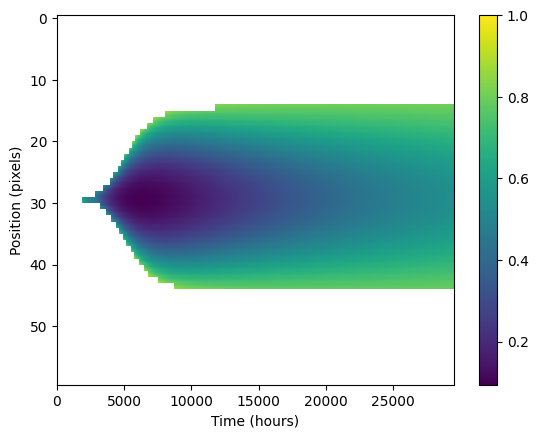

In [45]:
plt.imshow(umask[:,int(nx//2),:].transpose(), aspect='auto') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()
#plt.contour(u[10:,int(nx//2),:].transpose(), [0.025])
plt.xlabel('Time (hours)')
plt.ylabel('Position (pixels)')

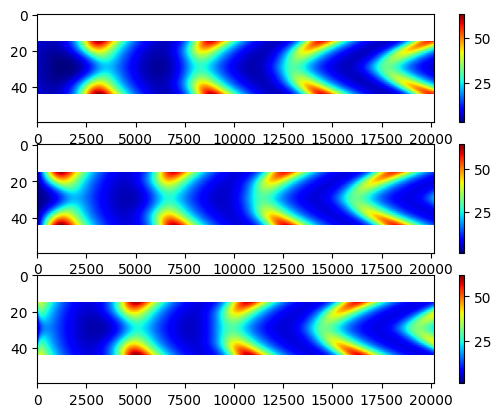

In [46]:
plt.subplot(3,1,1)
plt.imshow(pmask[:,int(nx//2),:,0].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(pmask[:,int(nx//2),:,1].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

plt.subplot(3,1,3)
plt.imshow(pmask[:,int(nx//2),:,2].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

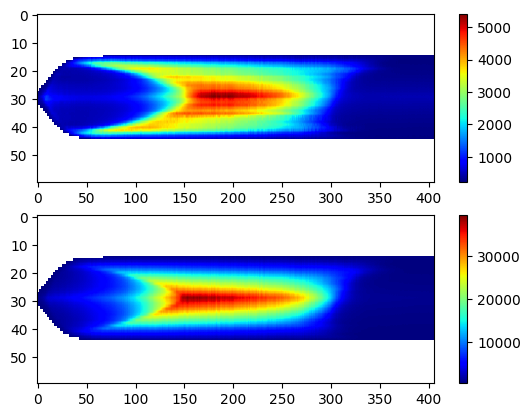

In [47]:
plt.subplot(2,1,1)
plt.imshow(crop_im[:,int(nx//2),:,0].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

plt.subplot(2,1,2)
plt.imshow(crop_im[:,int(nx//2),:,1].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

In [24]:
from scipy.signal import savgol_filter

def compute_rho(x, y, w=21):
    rho_01 = x / y # pmask[:,:,:,0] / pmask[:,:,:,1]
    #rho_02 = pmask[:,:,:,0] / pmask[:,:,:,2]
    #rho_12 = pmask[:,:,:,1] / pmask[:,:,:,2]

    lrho_01 = np.log(rho_01)
    dslrho_01 = savgol_filter(lrho_01, w, 3, deriv=1, axis=0)
    #lrho_02 = np.log(rho_02)
    #dslrho_02 = savgol_filter(lrho_02, w, 3, deriv=1, axis=0)
    #lrho_12 = np.log(rho_12)
    #dslrho_12 = savgol_filter(lrho_12, w, 3, deriv=1, axis=0)

    #return rho_01,rho_02,rho_12, dslrho_01,dslrho_02,dslrho_12
    return rho_01,dslrho_01

In [777]:
from scipy.signal import find_peaks

def compute_wave(data, edt0):
    pks = np.zeros((nx,ny))
    mags = np.zeros((nx,ny)) + np.nan
    for x in range(nx):
        for y in range(ny):
            s = data[:,x,y]
            #pk = find_peaks(s)[0]
            #if len(pk)>0:
            #    pks[x,y] = pk[0]
            #    mags[x,y] = s[pk[0]]
            pks[x,y] = np.argmax(s)
            mags[x,y] = s[int(pks[x,y])]

    t_centre = pks[edt0==edt0.max()].mean()
    t_edge = pks[edt0==edt0[edt0>0].min()].mean()
    pkdiff =  t_centre - t_edge
    print(pkdiff)
    tdiff = pkdiff * dt / 60 / 60
    if tdiff>0:
        speed = edt0.max() / tdiff
    else:
        speed = 0
    mag = np.nanmean(mags)
    return speed,mag,t_centre

In [682]:
rho_01,dslrho_01 = compute_rho(pmask[:,:,:,3], pmask[:,:,:,4])
rho_02,dslrho_02 = compute_rho(pmask[:,:,:,3], pmask[:,:,:,5])
rho_12,dslrho_12 = compute_rho(pmask[:,:,:,4], pmask[:,:,:,5])

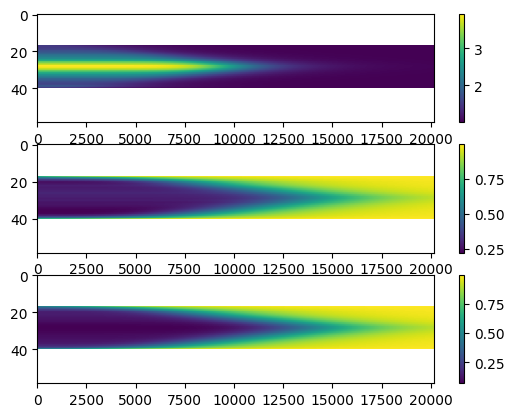

In [683]:
plt.subplot(3,1,1)
plt.imshow(rho_01[:,int(nx//2),:].transpose(), aspect='auto') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(rho_02[:,int(nx//2),:].transpose(), aspect='auto') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

plt.subplot(3,1,3)
plt.imshow(rho_12[:,int(nx//2),:].transpose(), aspect='auto') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

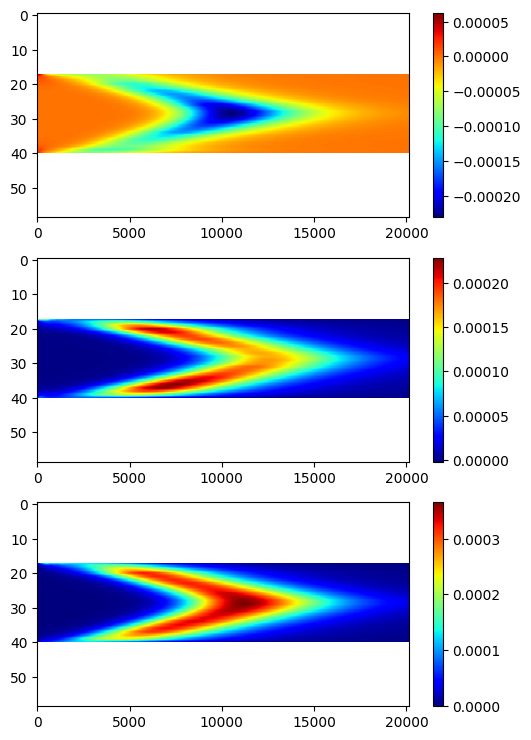

In [684]:
from scipy.signal import savgol_filter

plt.figure(figsize=(6,9))

lrho_01 = np.log(rho_01)
dslrho_01 = savgol_filter(lrho_01, 21, 3, deriv=1, axis=0)

plt.subplot(3,1,1)
plt.imshow(dslrho_01[:,int(nx//2),:].transpose(), cmap='jet', aspect='auto') #, vmin=-3e-3, vmax=3e-3) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

lrho_02 = np.log(rho_02)
dslrho_02 = savgol_filter(lrho_02, 21, 3, deriv=1, axis=0)

plt.subplot(3,1,2)
plt.imshow(dslrho_02[:,int(nx//2),:].transpose(), cmap='jet', aspect='auto') #, vmin=-3e-3, vmax=3e-3) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

lrho_12 = np.log(rho_12)
dslrho_12 = savgol_filter(lrho_12, 21, 3, deriv=1, axis=0)

plt.subplot(3,1,3)
plt.imshow(dslrho_12[:,int(nx//2),:].transpose(), cmap='jet', aspect='auto') #, vmin=-3e-3, vmax=3e-3) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

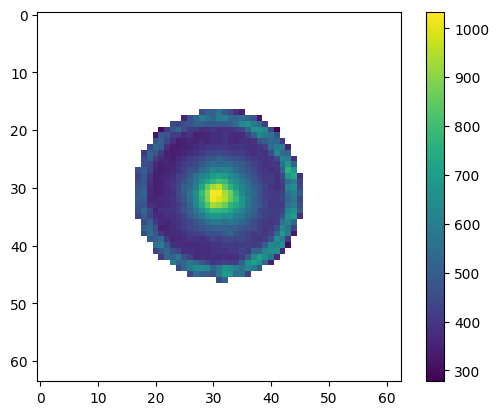

In [81]:
plt.imshow(pmask[0,:,:,0])
plt.colorbar()

KeyboardInterrupt: 

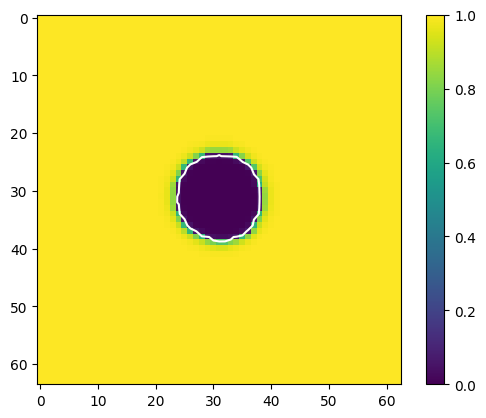

In [55]:
for ti in range(0, nt, 10):
    plt.imshow(u[ti,:,:], vmin=0, vmax=1)
    plt.colorbar()
    plt.contour(mask[ti,:,:], [0.5], colors=['w'])
    plt.savefig('u_%04d.png'%ti)
    plt.close()


In [27]:
from scipy.interpolate import interp1d

def residuals(x):
    print(np.exp(x))
    kappa, gamma, K, rep00, rep01, rep02, gamma_repr, KK0, KK1, KK2, KK3, nn = np.exp(x)
    ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
    umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
    uu = umask[:-1,:,:]
    ts2 = np.arange(np.floor(8 * 60 * 60 // dt), np.floor(36 * 60 * 60 // dt))
    u = uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:]
    pmask = solve_gene_expression(rep00, rep01, rep02, u, 1, 1, 1, 1, K, K, K, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp, ts2)

    p = pmask[60 * 20:-1:60,:,:,:]
    u = u[60 * 20:-1:60,:,:]
    mrho,mdslrho = compute_rho(p[:,:,:,2], p[:,:,:,3])  
    #denom = (1 + (u / KK2)**nn) * (1 + (u / KK3)**nn)
    #mdslrho = ( (1 + KK2**nn) * (u / KK2)**nn / p[:,:,:,2] / (1 + (p[:,:,:,1]/K)**n) - (1 + KK3**nn) * (u / KK3)**nn / p[:,:,:,3] ) / denom * 60 * 10
    #r2 = (1 + KK2**nn) * (u / KK2)**nn / (1 + (u / KK2)**nn) / p[:,:,:,2] / (1 + (p[:,:,:,1]/K)**n)
    #r3 = (1 + KK3**nn) * (u / KK3)**nn / (1 + (u / KK3)**nn) / p[:,:,:,3]
    #r2 = hill(u, KK2, nn) / hill(1, KK2, nn) / (1 + (p[:,:,:,1]/K)**n) / p[:,:,:,2]
    #r3 = hill(u, KK3, nn) / hill(1, KK3, nn) / p[:,:,:,3]
    #mdslrho = (r2 - r3) * 60 * 10
    idx0 = int(8 * 60 * 60 // dt // 60)
    tidx0 = idx0 + 20
    tidx1 = int(36 * 60 * 60 // dt // 60)
    resid = mdslrho[:,int(nx//2),:] - dslrho[tidx0:tidx1,int(nx//2),:]
    idx = np.isfinite(np.array(resid))
    resid = resid[idx].ravel()
    mse = np.mean(resid*resid)
    print(f'mse = {mse}')
    return resid
    #return mse

In [28]:
from scipy.optimize import least_squares, fmin, minimize

rep00,rep01,rep02 = 5,1e-3,1e-3
alpha0,alpha1,alpha2,alpha3 = 1,1,1,1
alpha = 1
beta0,beta1,beta2 = 0,0,0 # 1e-3,1e-3,1e-3
K0,K1,K2 = 1,1,1
K = 1
KK0,KK1,KK2,KK3 = 1,1,1,1
n = 2
nn = 1
#kappa = 1e-14
gamma = 1
gamma_fp = np.log(2) / (12 * 60 * 60)
gamma_repr = np.log(2) / (1 * 60 * 60)
dx = 16e-6
dt = 10
t0 = 0

#ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
#umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
#uu = umask[:-1,:,:]

rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1])  

#kappa, rep00, rep01, rep02,K,gamma_repr,KK0,KK1,KK2,KK3,nn = [1.90477568e-13, 2.40914790e-02, 1.23843785e+00, 3.67041049e+03, 2.42493865e+03, 2.92348718e-04, 4.55484789e-01, 3.22305581e-01, 2.66946556e-01, 2.84130169e-01, 6.74474278e+00]
#kappa,gamma,rep00, rep01, rep02,K,gamma_repr,KK0, KK1, KK2, KK3, nn = [1.46369824e-13, 5.41780938e+00, 2.41599534e+02, 1.02036301e+03, 4.45643474e+00, 1.71248412e+03, 3.20572744e-04, 2.29179548e-01, 3.54992148e-02, 4.78930529e-02, 4.24058609e-02, 9.59379329e+00]
#alpha0,alpha1,alpha2,alpha3,kappa,gamma,rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_alphas_no_Ks.npy')
kappa,gamma, K, rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_balanced.npy')
lb = [1e-14, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, gamma_repr / 10, 1e-6, 1e-6, 1e-6, 1e-6, 1]
ub = [1e-12, 1e6, 1e6, 1e6, 1e6, 1e6, gamma_repr * 10, 1e6, 1e6, 1e6, 1e6, 50]
bounds = np.log([lb,ub])
res = least_squares(residuals, np.log([kappa,gamma, K, rep00, rep01, rep02, gamma_repr, KK0, KK1, KK2, KK3, nn]), bounds=bounds, ftol=1e-3)

[1.28155283e-13 9.34268251e+00 2.67866510e+03 2.41940439e+03
 2.85109606e+03 2.73605014e+00 2.22628720e-04 1.31532700e-01
 1.18591322e-03 1.49855653e-03 6.20446719e-05 1.56821923e+01]
14760


KeyboardInterrupt: 

In [96]:
print(np.exp(res.x))
print(np.log(2) / gamma_repr / 60)
print(res.grad)

[1.28155283e-13 9.34268251e+00 2.67866510e+03 2.41940439e+03
 2.85109606e+03 2.73605014e+00 2.22628720e-04 1.31532700e-01
 1.18591322e-03 1.49855653e-03 6.20446719e-05 1.56821923e+01]
51.42440236022371
[ 5.09314158e-04  2.85625315e-04  2.18599655e-04 -6.39579142e-05
 -5.01402260e-05  1.99381020e-06  6.13238794e-04 -9.09633798e-05
  1.08566529e-04 -3.18429638e-05  0.00000000e+00 -2.34518946e-04]


In [105]:
#np.save('xopt_single_alphas_no_Ks.npy', np.exp(res.x))
np.save('xopt_single_balanced.npy', np.exp(res.x))

In [29]:
#alpha0, alpha1, alpha2, alpha3, kappa, gamma, rep00, rep01, rep02, gamma_repr, KK0, KK1, KK2, KK3, nn = np.exp(res.x)
#alpha0,alpha1,alpha2,alpha3,kappa,gamma,rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_alphas_no_Ks.npy')
#kappa,gamma, K, rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.exp(res.x)
kappa,gamma, K, rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_balanced.npy')

ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
uu = umask[:-1,:,:]
ts2 = np.arange(np.floor(8 * 60 * 60 // dt), np.floor(36 * 60 * 60 // dt))
u = uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:]
pmask = solve_gene_expression(rep00, rep01, rep02, u, 1, 1, 1, 1, K, K, K, n, gamma_repr, KK0, KK1, KK2, KK3, 4, gamma_fp, ts2)

print(np.nanmin(pmask))
print(pmask.shape)
p = pmask[60 * 20:-1:60,:,:,:]
mrho,mdslrho = compute_rho(p[:,:,:,2], p[:,:,:,3])  
rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1])

14760
10080
2.73605014357914
(10081, 60, 59, 4)


In [30]:
print(f'K = {K}')
print(f'KK0 = {KK0}')
print(f'KK1 = {KK1}')
print(f'KK2 = {KK2}')
print(f'KK3 = {KK3}')
print(f'nn = {nn}')
print(f'kappa, gamma = {kappa,gamma}')
print(f'rep0 = {rep00, rep01, rep02}')
print(f'Repressor half life = {np.log(2) / gamma_repr / 60} mins')


K = 2678.665103943869
KK0 = 0.13153270028365505
KK1 = 0.0011859132237181818
KK2 = 0.001498556527152728
KK3 = 6.204467190457258e-05
nn = 15.682192315083379
kappa, gamma = (1.2815528268945298e-13, 9.342682508568592)
rep0 = (2419.4043863640472, 2851.0960585220946, 2.73605014357914)
Repressor half life = 51.89111730421959 mins


/var/folders/k8/h6brl0ns6vz0_mrl3gdnlzj00000gn/T/ipykernel_11960/1639711920.py:6: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(x), y, '.')


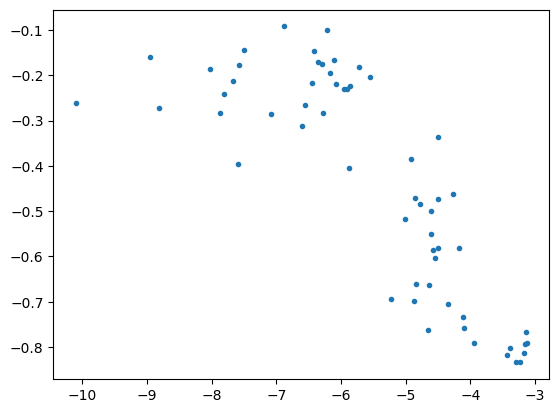

In [110]:
idx0 = int(8 * 60 * 60 // dt // 60)
idx1 = int(36 * 60 * 60 // dt // 60)

x = dslrho[idx0+20:idx1,ix,iy]
y = corr[idx0+20:idx1,ix,iy]
plt.plot(np.log(x), y, '.')

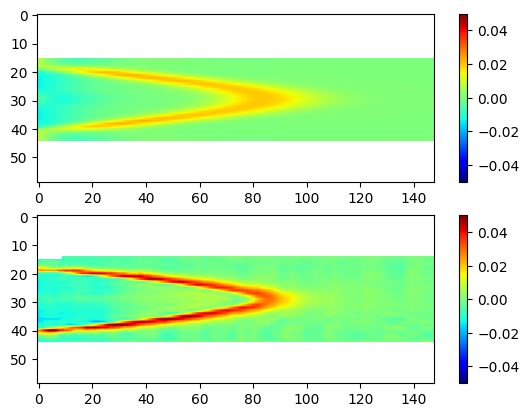

In [31]:
plt.subplot(2, 1, 1)
plt.imshow(mdslrho[:,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

idx0 = int(8 * 60 * 60 // dt // 60)
idx1 = int(36 * 60 * 60 // dt // 60)

plt.subplot(2, 1, 2)
plt.imshow(dslrho[idx0+20:idx1,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

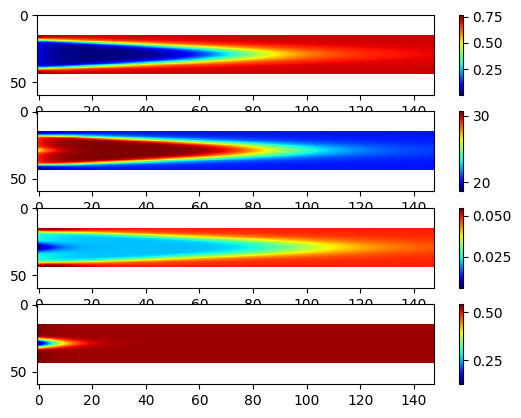

In [245]:
plt.subplot(4, 1, 1)
plt.imshow(p[:,int(nx//2),:,0].transpose(), aspect='auto', cmap='jet')
plt.colorbar()
plt.subplot(4, 1, 2)
plt.imshow(p[:,int(nx//2),:,1].transpose(), aspect='auto', cmap='jet')
plt.colorbar()
plt.subplot(4, 1, 3)
plt.imshow(p[:,int(nx//2),:,2].transpose(), aspect='auto', cmap='jet')
plt.colorbar()
plt.subplot(4, 1, 4)
plt.imshow(p[:,int(nx//2),:,3].transpose(), aspect='auto', cmap='jet')
plt.colorbar()

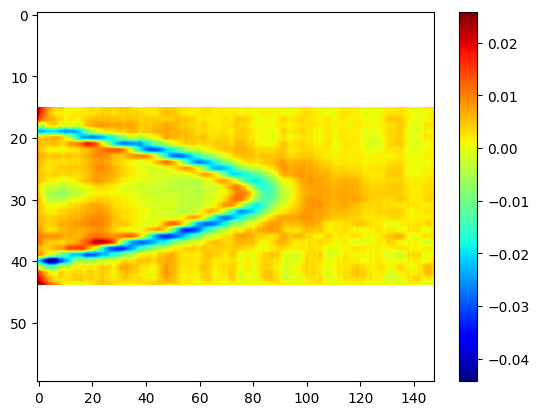

In [246]:
err = mdslrho[:,int(nx//2),:] - dslrho[idx0+20:idx1,int(nx//2),:]
plt.imshow(err.transpose(), aspect='auto', cmap='jet')
plt.colorbar()

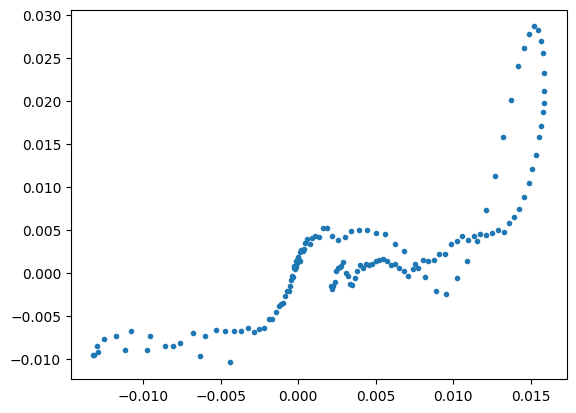

In [247]:
plt.plot(mdslrho[:,int(nx//2),int(ny//2)].ravel(), dslrho[idx0+20:idx1,int(nx//2),int(ny//2)].ravel(), '.')

In [248]:
x,y = mdslrho[:,int(nx//2),int(ny//2)].ravel(), dslrho[idx0+20:idx1,int(nx//2),int(ny//2)].ravel()
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
np.corrcoef(x, y)

array([[1.        , 0.81290669],
       [0.81290669, 1.        ]])

In [71]:
from scipy.signal import correlate, correlation_lags

cc = correlate(x, y)
lags = correlation_lags(len(x), len(y))

-3


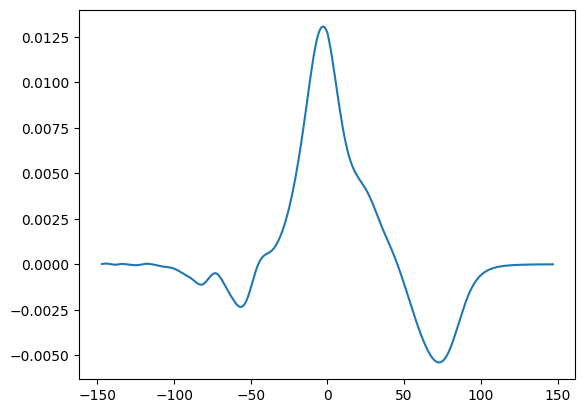

In [72]:
plt.plot(lags, cc)
print(lags[np.argmax(cc)])

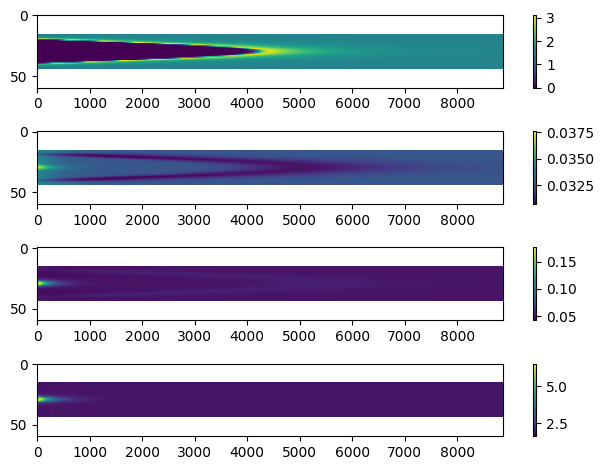

In [249]:
uuu = uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:]
uuu = uuu[60*20:,int(nx//2),:]
x = uuu # [~np.isnan(uuu)].ravel() # np.logspace(-2, 0, 100)
y0 = hill(x, KK0, nn) / hill(1, KK0, nn) / (1 + (pmask[60*20:-1,int(nx//2),:,2]/K2)**n) / pmask[60*20:-1,int(nx//2),:,0]
plt.subplot(4, 1, 1)
plt.imshow(y0.transpose(), aspect='auto')
plt.colorbar()
y1 = hill(x, KK1, nn) / hill(1, KK1, nn) / (1 + (pmask[60*20:-1,int(nx//2),:,0]/K0)**n) / pmask[60*20:-1,int(nx//2),:,1]
plt.subplot(4, 1, 2)
plt.imshow(y1.transpose(), aspect='auto')
plt.colorbar()
y2 = hill(x, KK2, nn) / hill(1, KK2, nn) / (1 + (pmask[60*20:-1,int(nx//2),:,1]/K1)**n) / pmask[60*20:-1,int(nx//2),:,2]
plt.subplot(4, 1, 3)
plt.imshow(y2.transpose(), aspect='auto')
plt.colorbar()
y3 = hill(x, KK3, nn) / hill(1, KK3, nn) / pmask[60*20:-1,int(nx//2),:,3]
plt.subplot(4, 1, 4)
plt.imshow(y3.transpose(), aspect='auto')
plt.colorbar()

plt.tight_layout()

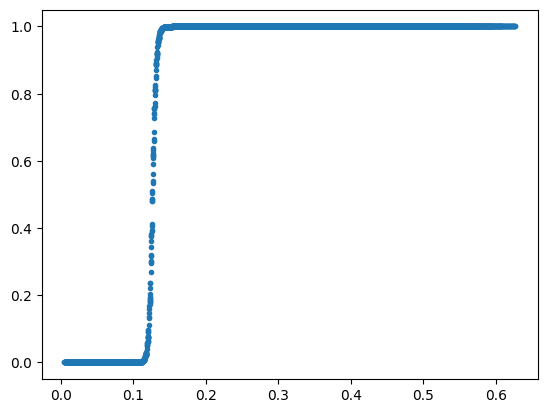

In [78]:
plt.plot(x.ravel(), hill(x.ravel(), KK0, nn), '.')

/var/folders/k8/h6brl0ns6vz0_mrl3gdnlzj00000gn/T/ipykernel_1677/1093538869.py:11: RuntimeWarning: invalid value encountered in sqrt
  corr = covw[:,:,0,1] / np.sqrt(covw[:,:,0,0] * covw[:,:,1,1])


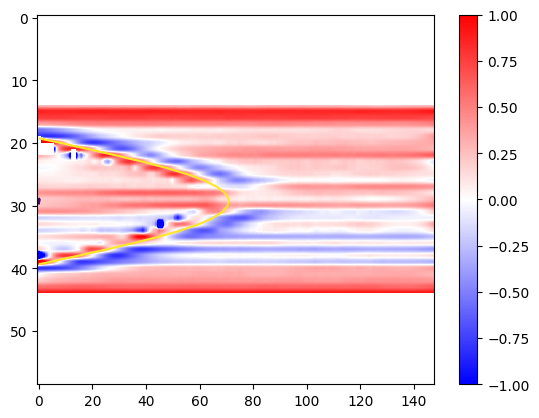

In [73]:
uuu = uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:]
uuu = uuu[20 * 60:-1:60,int(nx//2),:]
x = uuu 

c = cov[idx0+20:idx1,int(nx//2),:,:,:]
dcdt = savgol_filter(c, 31, 3, deriv=1, axis=0)
sc = savgol_filter(c, 31, 3, deriv=0, axis=0)

gamma_fp = np.log(2) / (1 * 60 / 10)
covw = dcdt + 2 * gamma_fp * sc
corr = covw[:,:,0,1] / np.sqrt(covw[:,:,0,0] * covw[:,:,1,1])
plt.imshow(corr.transpose(), aspect='auto', vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()

plt.contour(x.transpose(), np.sort([KK0,KK1,KK2,KK3]))

(128,)
(406, 60, 60)
10080
0.00023176717836548728
(10081, 60, 60, 4)
10080
1.964941827337912e-05
(10081, 60, 60, 4)
10080
9.29201091349683e-06
(10081, 60, 60, 4)
10080
3.75350687095105e-06
(10081, 60, 60, 4)
10080
2.148416647251104e-06
(10081, 60, 60, 4)
10080
1.4687480368745107e-06
(10081, 60, 60, 4)
10080
1.1138027645849755e-06
(10081, 60, 60, 4)
10080
9.023139354053247e-07
(10081, 60, 60, 4)
10080
7.644763305671331e-07
(10081, 60, 60, 4)
10080
6.686122238952366e-07
(10081, 60, 60, 4)


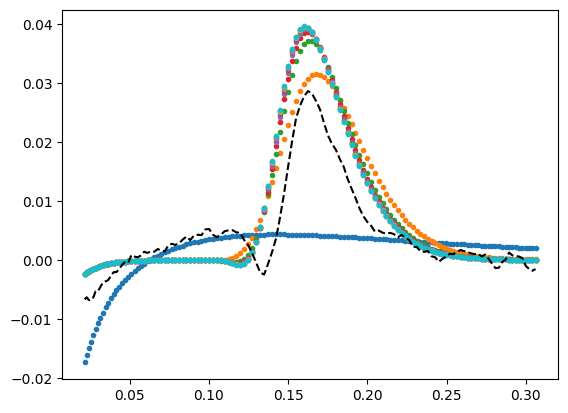

In [267]:
uuu = uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:]
uuu = uuu[60 * 40:-1:60,int(nx//2),int(ny//2)]
x = uuu 
print(x.shape)
print(dslrho.shape)

for nn in np.linspace(1, 100, 10):
    pmask = solve_gene_expression(rep00, rep01, rep02, uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:], alpha0, alpha1, alpha2, alpha3, 1, 1, 1, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp, ts2)

    print(np.nanmin(pmask))
    print(pmask.shape)
    p = pmask[60 * 40:-1:60,:,:,:]
    mrho,mdslrho = compute_rho(p[:,:,:,2], p[:,:,:,3])  
    rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1])
    plt.plot(x.ravel(), mdslrho[:,int(nx//2),int(ny//2)].ravel(), '.')
plt.plot(x.ravel(), dslrho[idx0+40:idx1,int(nx//2),int(ny//2)].ravel(), 'k--')

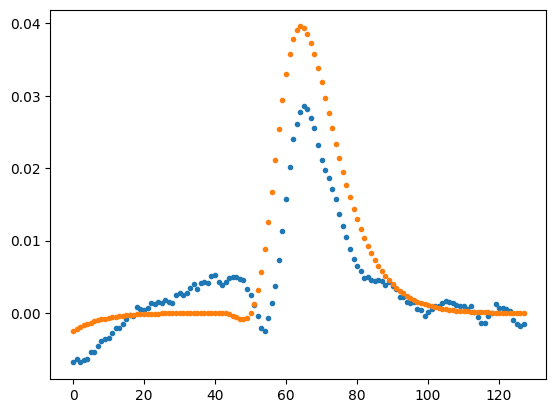

In [258]:
plt.plot(dslrho[idx0+40:idx1,int(nx//2),int(ny//2)].ravel(), '.')
plt.plot(mdslrho[20:,int(nx//2),int(ny//2)].ravel(), '.')

In [212]:
ppp = pmask[60*20:-1,int(nx//2),:,:]
denom = (1 + (uuu / KK2)**nn) * (1 + (uuu / KK3)**nn)
mdslrho = ( (1 + KK2**nn) * (uuu / KK2)**nn / ppp[:,:,2] / (1 + (ppp[:,:,1]/K)**n) - (1 + KK3**nn) * (uuu / KK3)**nn / ppp[:,:,3] ) / denom * 60 * 10


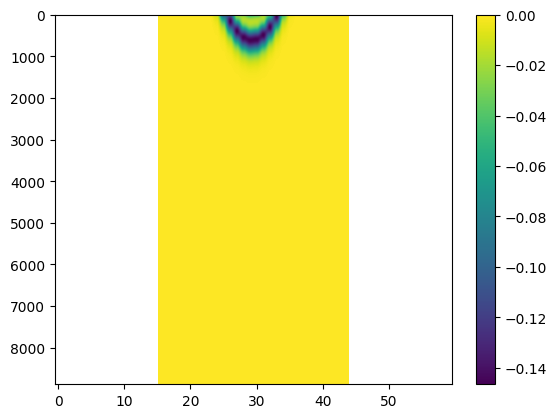

In [160]:
plt.imshow(mdslrho, aspect='auto')
plt.colorbar()

In [337]:
#alpha0, alpha1, alpha2, alpha3, kappa, gamma, rep00, rep01, rep02, gamma_repr, KK0, KK1, KK2, KK3, nn = np.exp(res.x)
#alpha0,alpha1,alpha2,alpha3,kappa,gamma,rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_alphas_no_Ks.npy')
#kappa,gamma, K, rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.exp(res.x)
kappa,gamma, K, rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_balanced.npy')

ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
uu = umask[:-1,:,:]
ts2 = np.arange(np.floor(8 * 60 * 60 // dt), np.floor(36 * 60 * 60 // dt))
u = uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:]

sigma_exp,sigma_deg = 1e-2,1e-2

niters = 100
piters = np.zeros((niters,148,nx,ny,4))
for iter in range(niters):
    print(f'Solving iteration {iter+1}/{niters}')
    pmask = solve_gene_expression_sde(rep00, rep01, rep02, u, 1, 1, 1, 1, K, K, K, n, gamma_repr, KK0, KK1, KK2, KK3, 4, gamma_fp, sigma_exp, sigma_deg, ts2)
    p = pmask[60 * 20:-1:60,:,:,:]
    piters[iter,:,:,:,:] = p
print(np.nanmin(piters))
print(piters.shape)
pmean = piters.mean(axis=0)
mrho,mdslrho = compute_rho(pmean[:,:,:,2], pmean[:,:,:,3])  
rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1])

14760
Solving iteration 1/100
10080
Solving iteration 2/100
10080
Solving iteration 3/100
10080
Solving iteration 4/100
10080
Solving iteration 5/100
10080
Solving iteration 6/100
10080
Solving iteration 7/100
10080
Solving iteration 8/100
10080
Solving iteration 9/100
10080
Solving iteration 10/100
10080
Solving iteration 11/100
10080
Solving iteration 12/100
10080
Solving iteration 13/100
10080
Solving iteration 14/100
10080
Solving iteration 15/100
10080
Solving iteration 16/100
10080
Solving iteration 17/100
10080
Solving iteration 18/100
10080
Solving iteration 19/100
10080
Solving iteration 20/100
10080
Solving iteration 21/100
10080
Solving iteration 22/100
10080
Solving iteration 23/100
10080
Solving iteration 24/100
10080
Solving iteration 25/100
10080
Solving iteration 26/100
10080
Solving iteration 27/100
10080
Solving iteration 28/100
10080
Solving iteration 29/100
10080
Solving iteration 30/100
10080
Solving iteration 31/100
10080
Solving iteration 32/100
10080
Solving ite

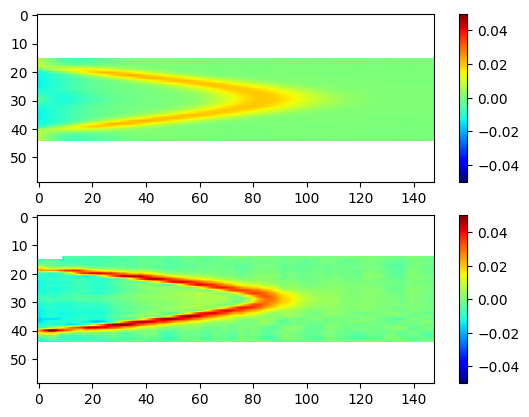

In [338]:
plt.subplot(2, 1, 1)
plt.imshow(mdslrho[:,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

idx0 = int(8 * 60 * 60 // dt // 60)
idx1 = int(36 * 60 * 60 // dt // 60)

plt.subplot(2, 1, 2)
plt.imshow(dslrho[idx0+20:idx1,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

In [339]:
ntt = piters.shape[1]
pcorr = np.zeros((ntt,nx,ny))
for t in range(ntt):
    for ix in range(nx):
        for iy in range(ny):
            x = piters[:,t,ix,iy,2]
            y = piters[:,t,ix,iy,3]
            pcorr[t,ix,iy] = np.corrcoef(x, y)[0,1]


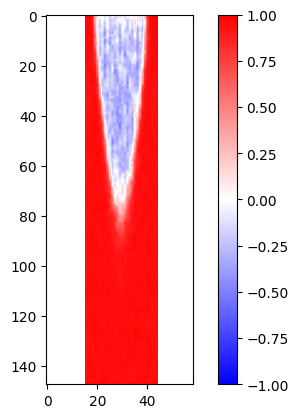

In [340]:
plt.imshow(pcorr[:,int(nx//2),:], vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()

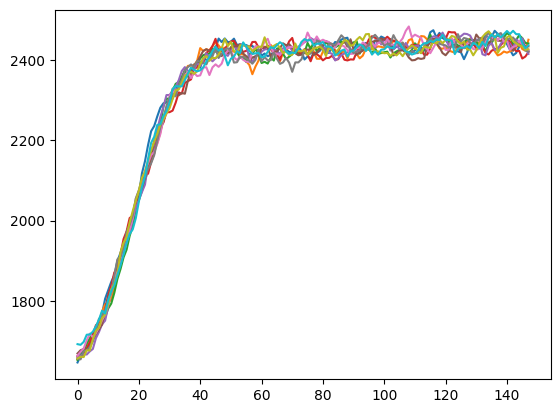

In [314]:
x = piters[:,:,40,30,2].transpose()
y = piters[:,50,int(nx//2),int(ny//2),3]
plt.plot(x)

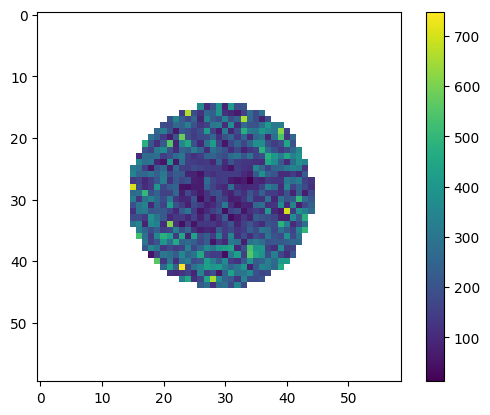

In [216]:
pvar = piters.var(axis=0)
plt.imshow(pvar[50,:,:,2])
plt.colorbar()

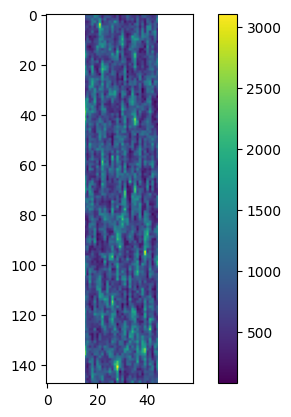

In [218]:
plt.imshow(pvar[:,int(nx//2),:,3])
plt.colorbar()